[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Fine-tuning Florence-2 on Object Detection Dataset

---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/florence-2/)
[![arXiv](https://img.shields.io/badge/arXiv-2311.06242-b31b1b.svg)](https://arxiv.org/abs/2311.06242)

Florence-2 is a lightweight vision-language model open-sourced by Microsoft under the MIT license. The model demonstrates strong zero-shot and fine-tuning capabilities across tasks such as captioning, object detection, grounding, and segmentation.

![Florence-2 Figure.1](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/florence-2-figure-1.png)

*Figure 1. Illustration showing the level of spatial hierarchy and semantic granularity expressed by each task. Source: Florence-2: Advancing a Unified Representation for a Variety of Vision Tasks.*

The model takes images and task prompts as input, generating the desired results in text format. It uses a DaViT vision encoder to convert images into visual token embeddings. These are then concatenated with BERT-generated text embeddings and processed by a transformer-based multi-modal encoder-decoder to generate the response.

![Florence-2 Figure.2](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/florence-2-figure-2.png)

*Figure 2. Overview of Florence-2 architecture. Source: Florence-2: Advancing a Unified Representation for a Variety of Vision Tasks.*



## Setup

### Configure your API keys

To fine-tune Florence-2, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `L4 GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Jun 25 11:02:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   46C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Download dataset from Roboflow Universe

In [2]:
!pip install -q roboflow
!pip install -q git+https://github.com/roboflow/supervision.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("roboflow-jvuqo").project("poker-cards-fmjio")
version = project.version(4)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to poker-cards-4 in coco:: 100%|██████████| 907/907 [00:00<00:00, 5318.89it/s]


In [4]:
import supervision as sv

ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
)

ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/valid",
    annotations_path=f"{dataset.location}/valid/_annotations.coco.json",
)

### Download example data

In [7]:
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!ls -lh

total 112K
-rw-r--r-- 1 root root 104K Jun  2  2023 dog.jpeg
drwxr-xr-x 5 root root 4.0K Jun 25 11:03 poker-cards-4
drwxr-xr-x 1 root root 4.0K Jun 21 13:28 sample_data


In [8]:
EXAMPLE_IMAGE_PATH = "dog.jpeg"

## Download and configure the model

In this step, you'll download the model checkpoint and configure it so that you can fine-tune it later on.

In [5]:
!pip install -q transformers flash_attn timm einops peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 31.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 73.4 MB/s eta 0:00:00


Load the model using `AutoModelForCausalLM` and the processor using `AutoProcessor` classes from the transformers library. Note that you need to pass `trust_remote_code` as `True` since this model is not a standard transformers model.

In [6]:
import torch
from transformers import AutoModelForCausalLM, AutoProcessor

CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION)

config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


### Run inference with pre-trained Florence-2 model

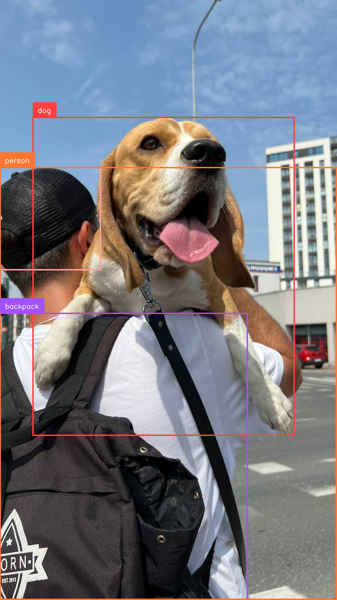

In [14]:
from PIL import Image

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<OD>"
text = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [15]:
from PIL import Image

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<DETAILED_CAPTION>"
text = "<DETAILED_CAPTION>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
response

{'<DETAILED_CAPTION>': 'In this image we can see a person wearing a bag and holding a dog. In the background there are buildings, poles and sky with clouds.'}

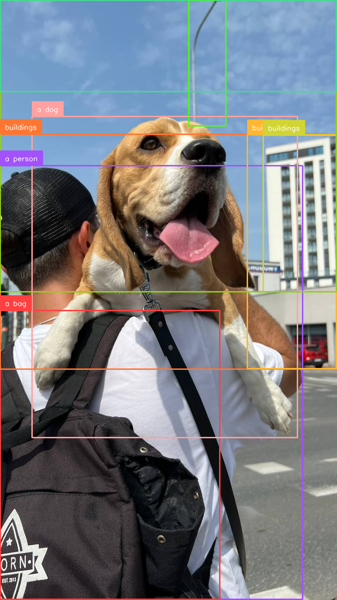

In [16]:
from PIL import Image

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<CAPTION_TO_PHRASE_GROUNDING>"
text = "<CAPTION_TO_PHRASE_GROUNDING> In this image we can see a person wearing a bag and holding a dog. In the background there are buildings, poles and sky with clouds."

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

## Fine-tune Florence-2 on custom dataset

### Setup DataLoaders

In [17]:
import cv2
import json
import numpy as np
from PIL import Image
from torch.utils.data import Dataset


TASK = "<OD>"


class DetectionsDataset(Dataset):
    def __init__(self, dataset: sv.DetectionDataset):
        self.dataset = dataset
        self.keys = list(dataset.images.keys())

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        keys = list(self.dataset.images.keys())
        key = self.keys[idx]
        image = self.dataset.images[key]
        annotations = self.dataset.annotations[key]
        h, w, _ = image.shape

        boxes = (annotations.xyxy / np.array([w, h, w, h]) * 1000).astype(int).tolist()
        labels = [self.dataset.classes[idx] for idx in annotations.class_id]

        prefix = TASK

        suffix_components = []
        for [x1, y1, x2, y2], label in zip(boxes, labels):
            suffix_component = f"{label}<loc_{x1}><loc_{y1}><loc_{x2}><loc_{y2}>"
            suffix_components.append(suffix_component)

        suffix = "".join(suffix_components)

        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        return prefix, suffix, image

In [22]:
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (AdamW, AutoProcessor, get_scheduler)

BATCH_SIZE = 6
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

train_dataset = DetectionsDataset(ds_train)
val_dataset = DetectionsDataset(ds_valid)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

### Setup LoRA

In [18]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=[
        "q_proj",
        "o_proj",
        "k_proj",
        "v_proj",
        "linear",
        "Conv2d",
        "lm_head",
        "fc2"
    ],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
    revision=REVISION
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 1,929,928 || all params: 272,733,896 || trainable%: 0.7076


In [19]:
torch.cuda.empty_cache()

### Run inference with pre-trained Florence-2 model on validation dataset


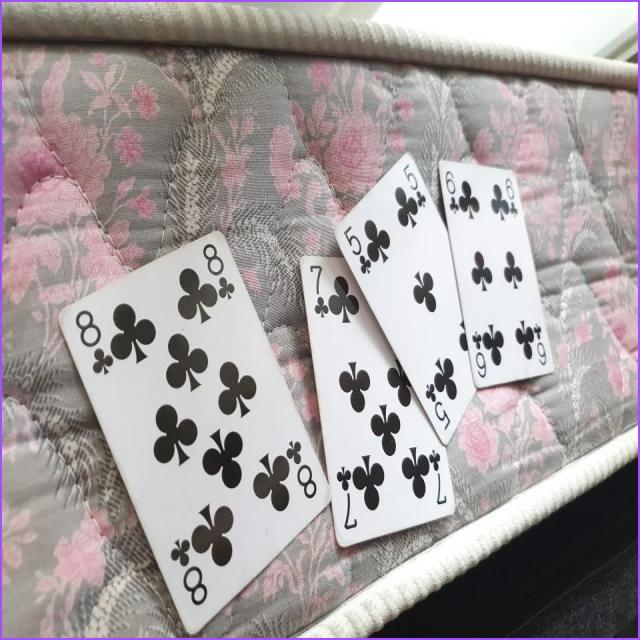
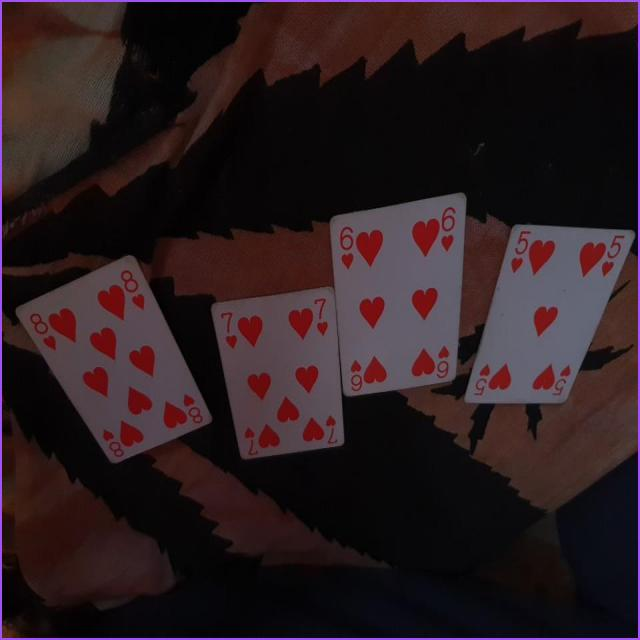
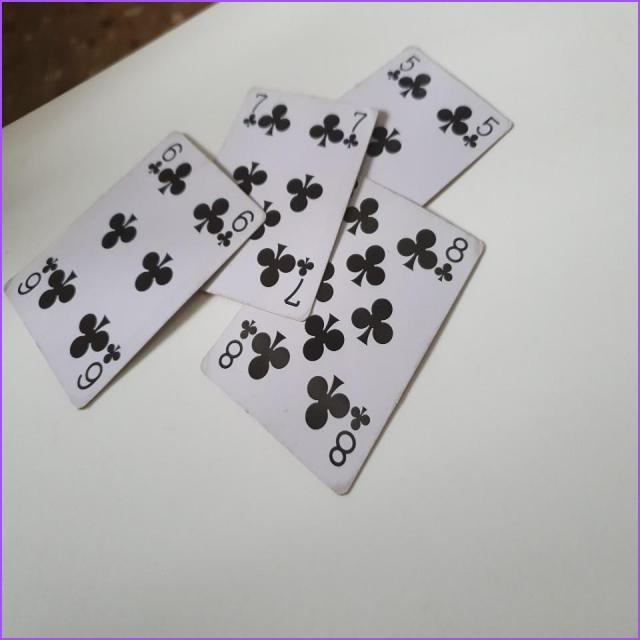
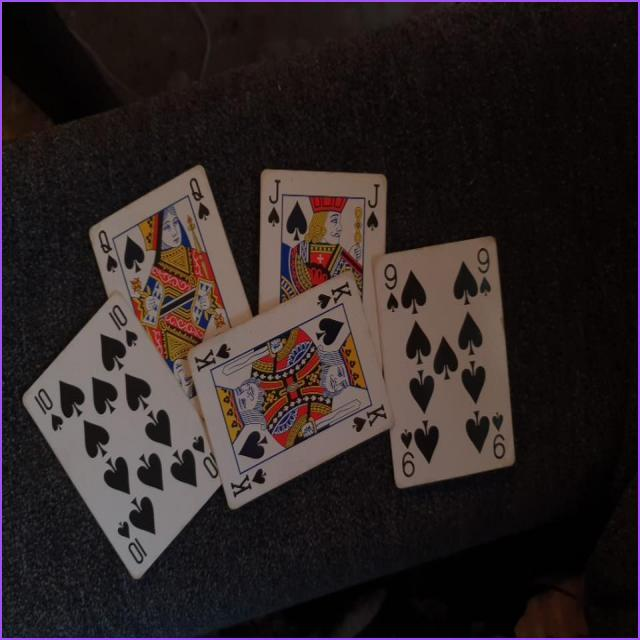

In [30]:
import io
import base64
import html
import itertools
from IPython.core.display import display, HTML

def render_inline(image, resize=(128, 128)):
    """Convert image into inline html."""
    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image, caption):
    h, w, _ = image.shape
    try:
        detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, caption, resolution_wh=(w, h))
        image = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), detections)
        image = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image, detections)
    except:
        print(caption)
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:256px; height:256px;" src="{render_inline(image, resize=(128, 128))}" />
    <p style="width:512px; margin:10px; font-size:small;">{html.escape(json.dumps(caption))}</p>
</div>
"""


def render_inference_and_render_results(model, dataset: sv.DetectionDataset, batch_size: int):
    html_out = ""
    for image_path, image, annotations in itertools.islice(dataset, batch_size):

        prefix = TASK
        image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        inputs = processor(text=prefix, images=image_pil, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        answer = processor.post_process_generation(generated_text, task=TASK, image_size=(image_pil.width, image_pil.height))
        html_out += render_example(image, answer)

    display(HTML(html_out))

render_inference_and_render_results(peft_model, ds_valid, 4)

### Fine-tuning

In [31]:
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    render_inference_and_render_results(peft_model, ds_valid, 6)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        i = -1
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            i += 1
            inputs, answers = batch

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, answers = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")

            render_inference_and_render_results(peft_model, ds_valid, 6)

        # Save model checkpoint
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)


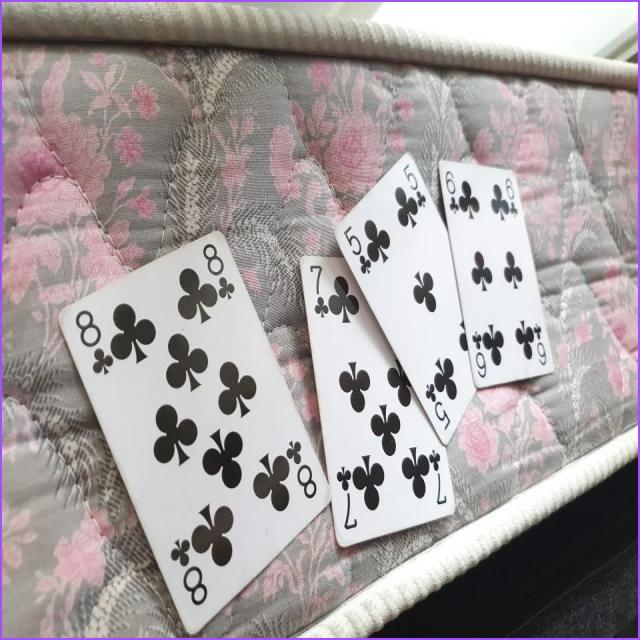
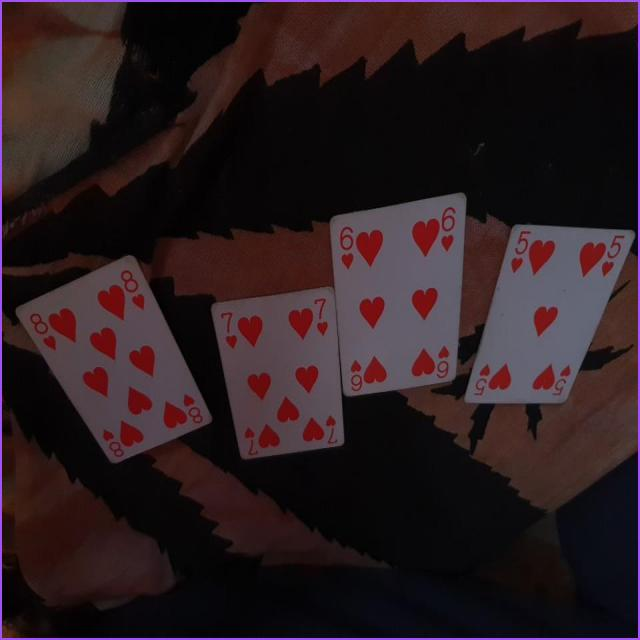
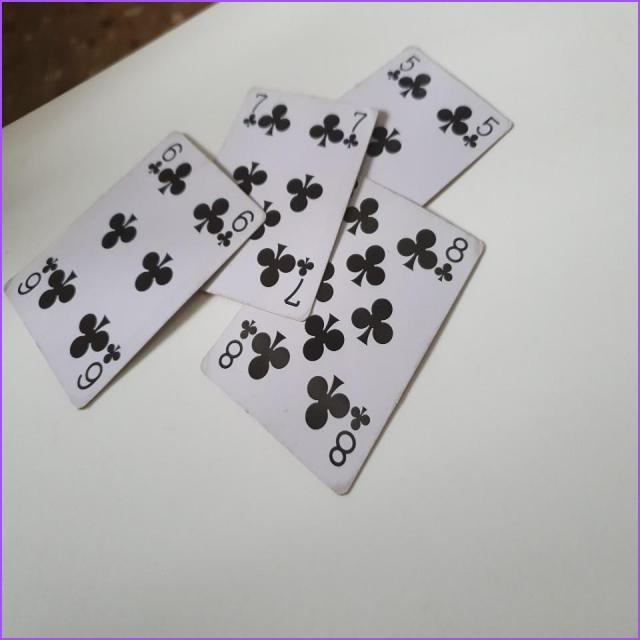
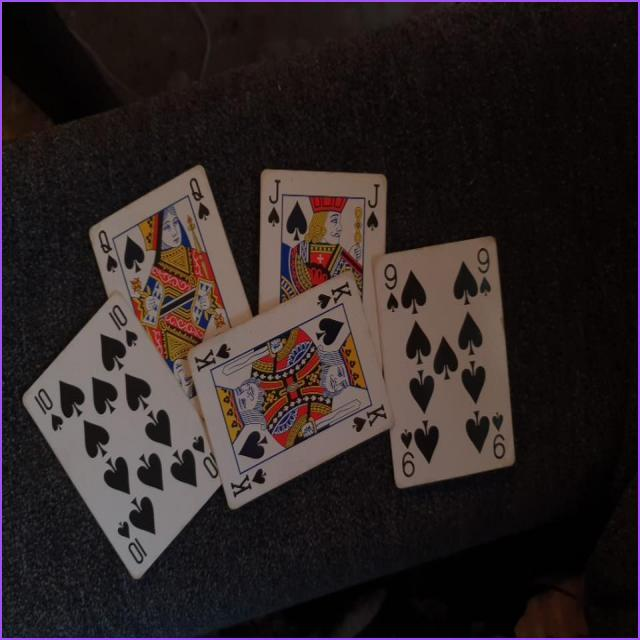
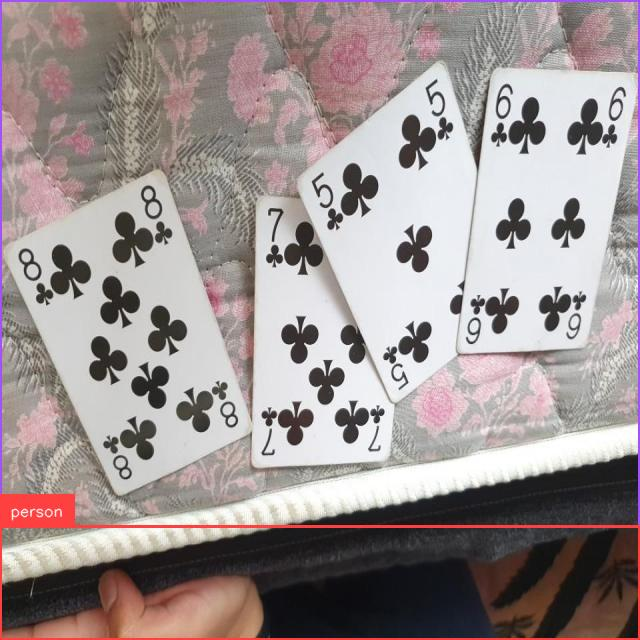
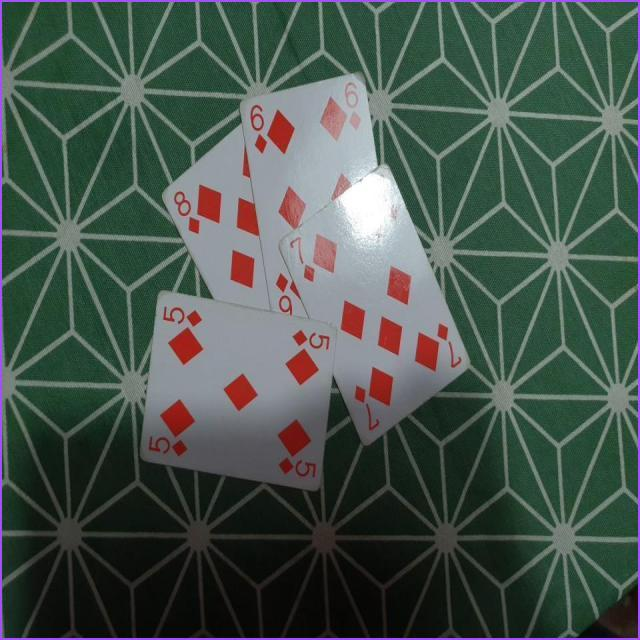

Training Epoch 1/5: 100%|██████████| 136/136 [03:39<00:00,  1.62s/it]


Average Training Loss: 5.11518399680362


Validation Epoch 1/5: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Average Validation Loss: 3.6391468942165375



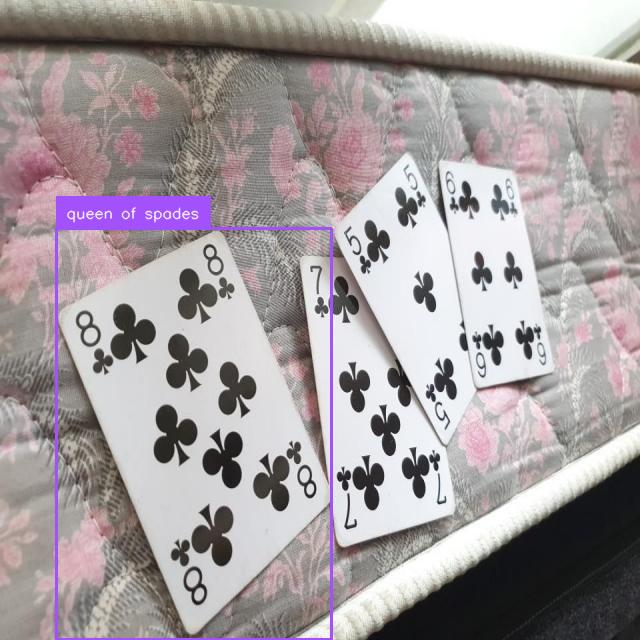
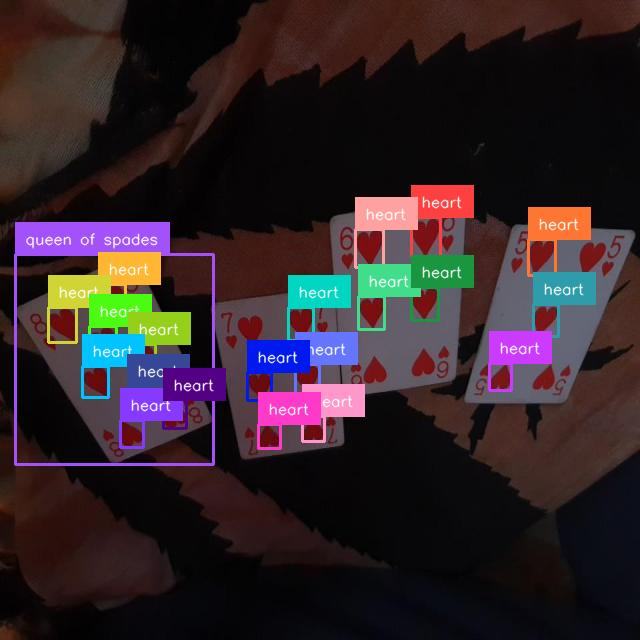
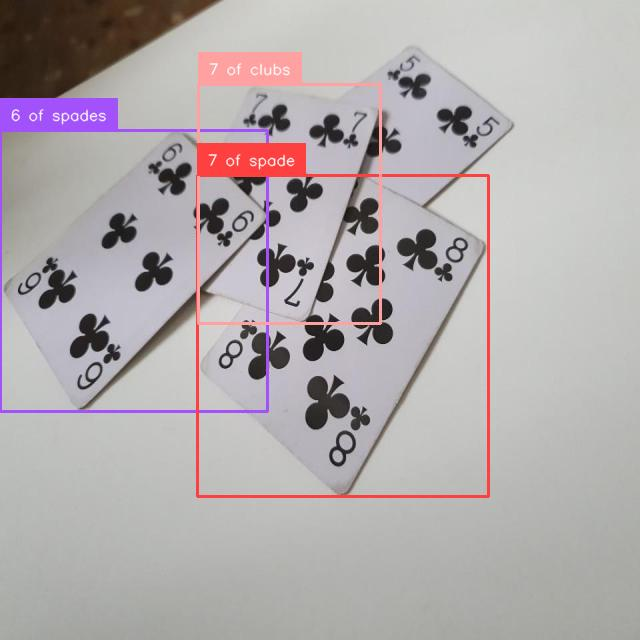
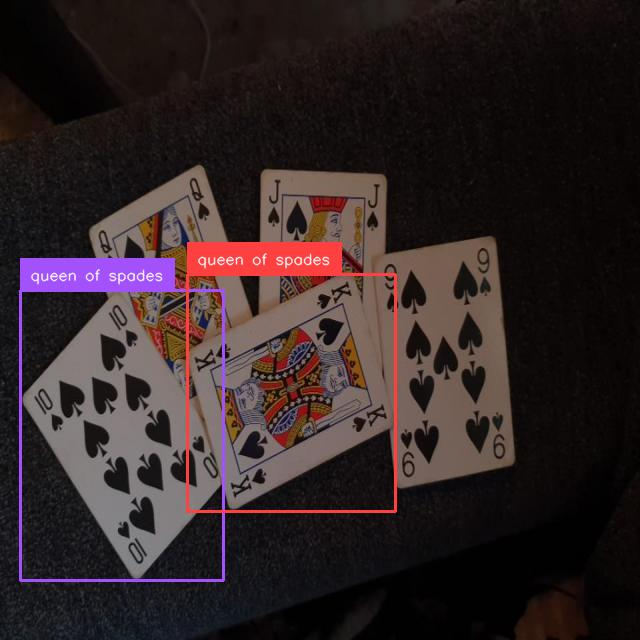
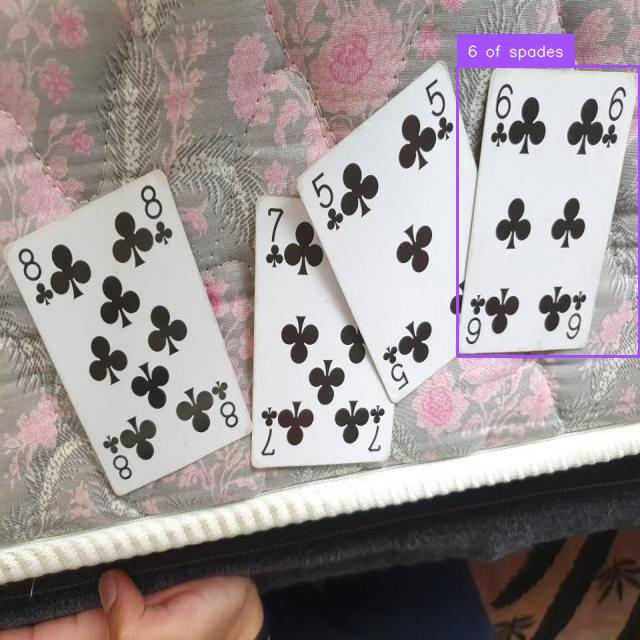
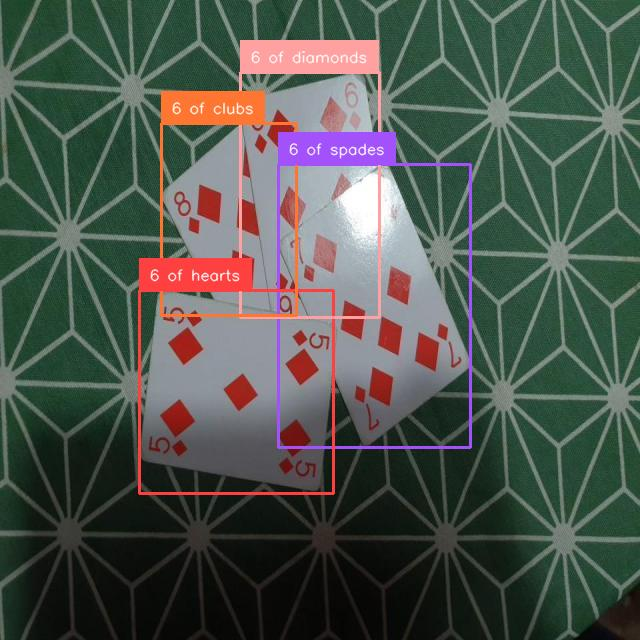

Training Epoch 2/5: 100%|██████████| 136/136 [03:39<00:00,  1.61s/it]


Average Training Loss: 3.653734392979566


Validation Epoch 2/5: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Average Validation Loss: 2.8643813133239746



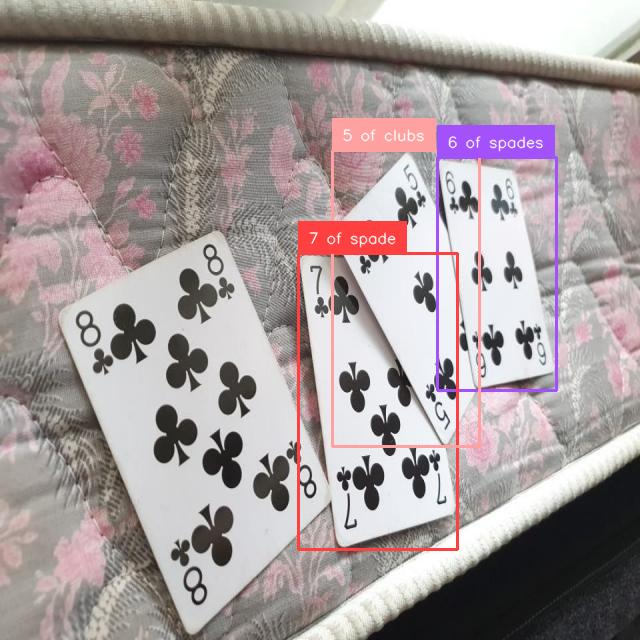
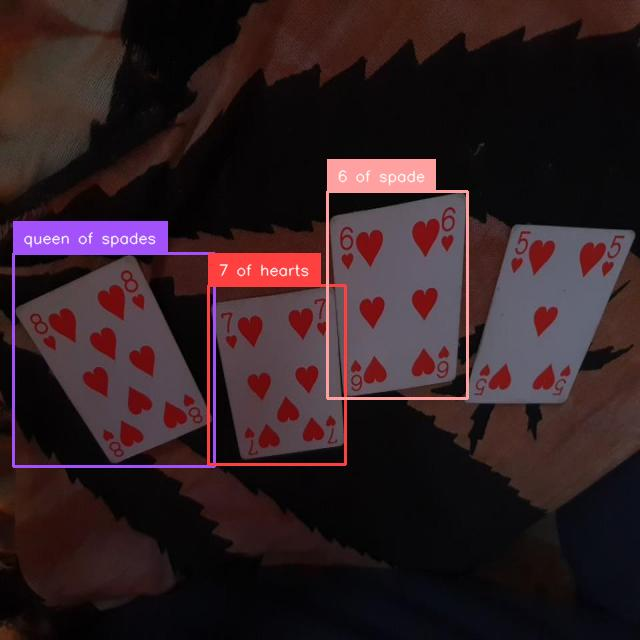
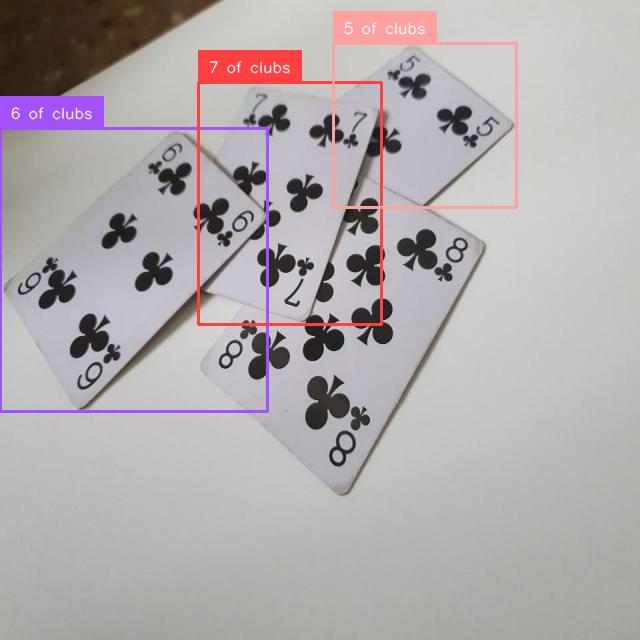
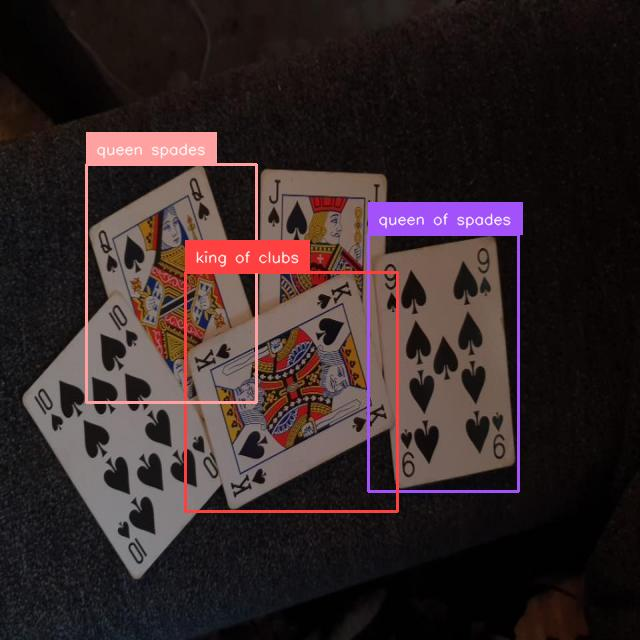
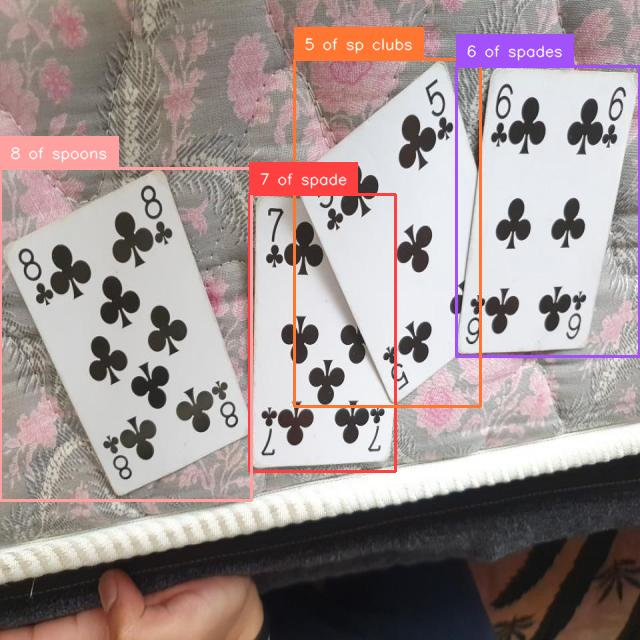
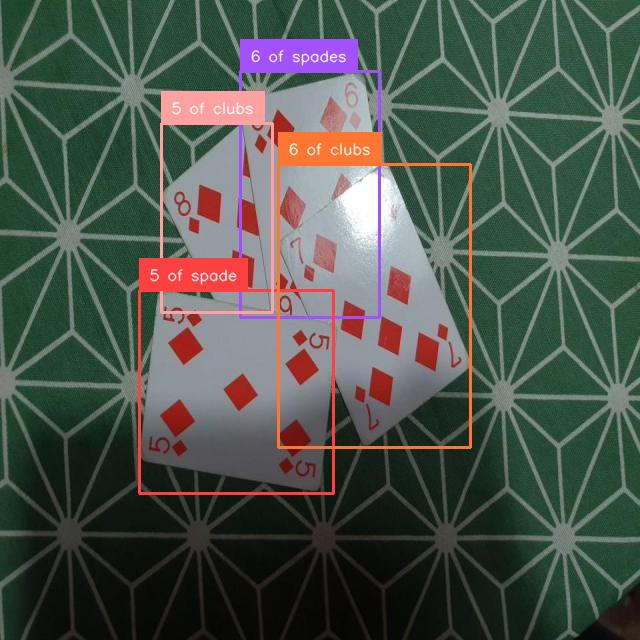

Training Epoch 3/5: 100%|██████████| 136/136 [03:39<00:00,  1.61s/it]


Average Training Loss: 2.9883793732699226


Validation Epoch 3/5: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Average Validation Loss: 2.2484600841999054



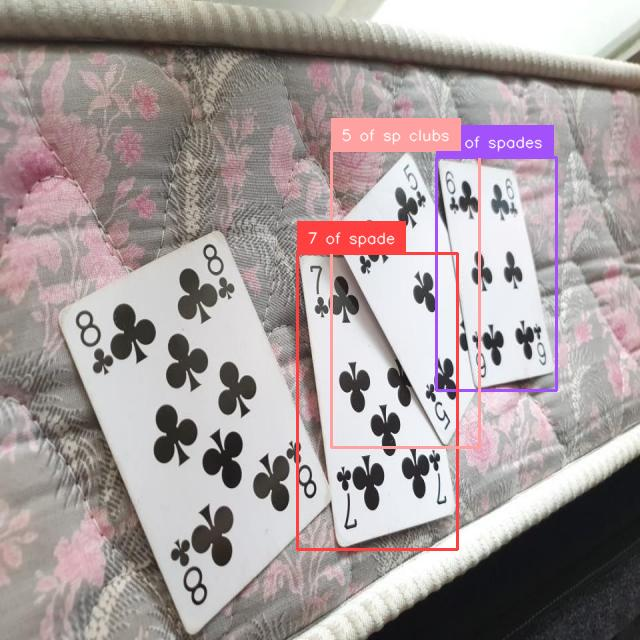
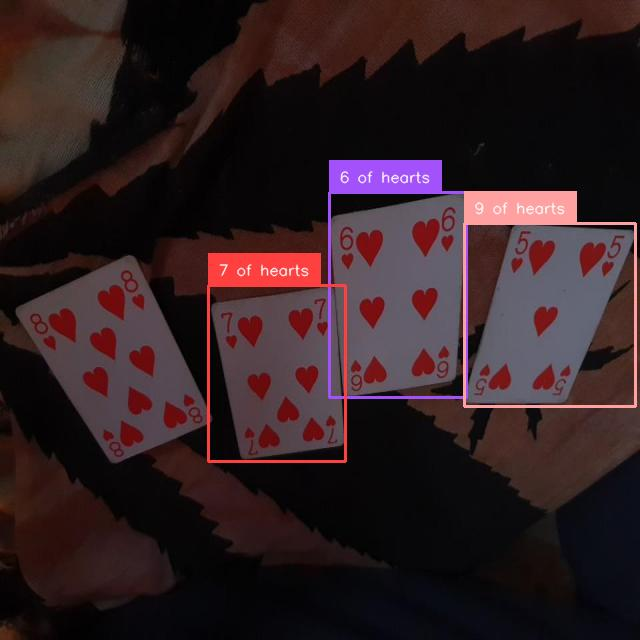
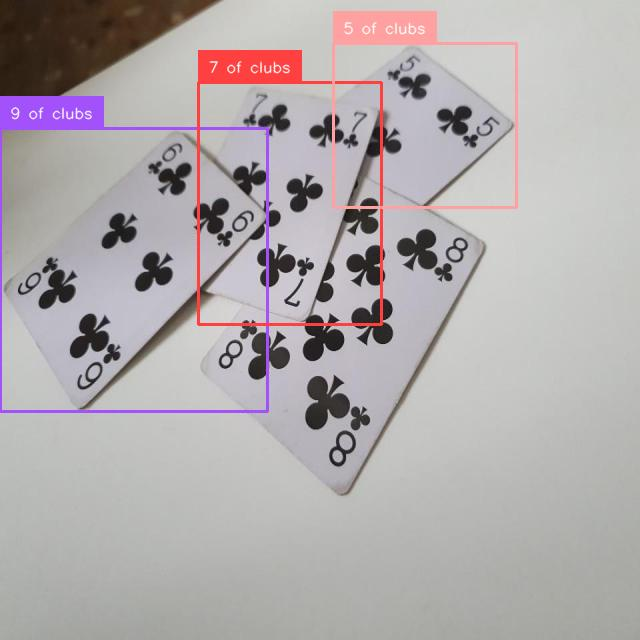
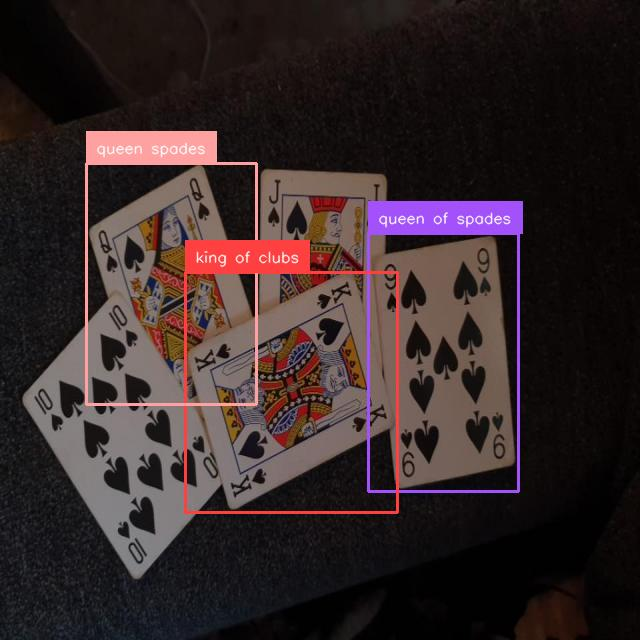
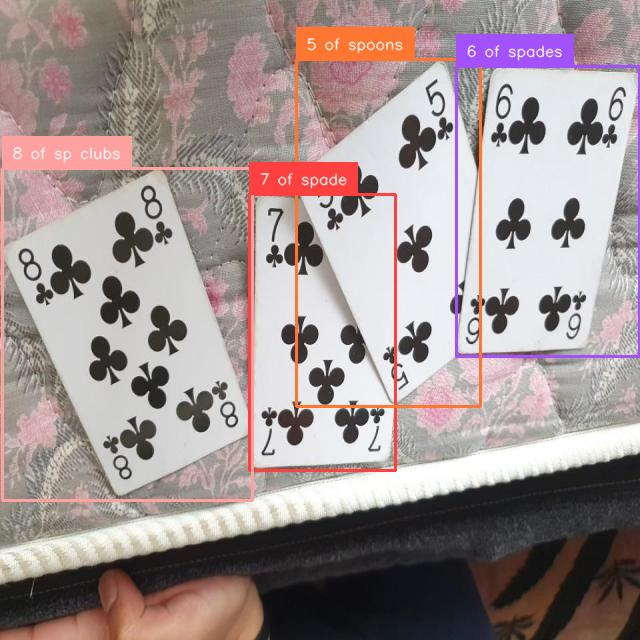
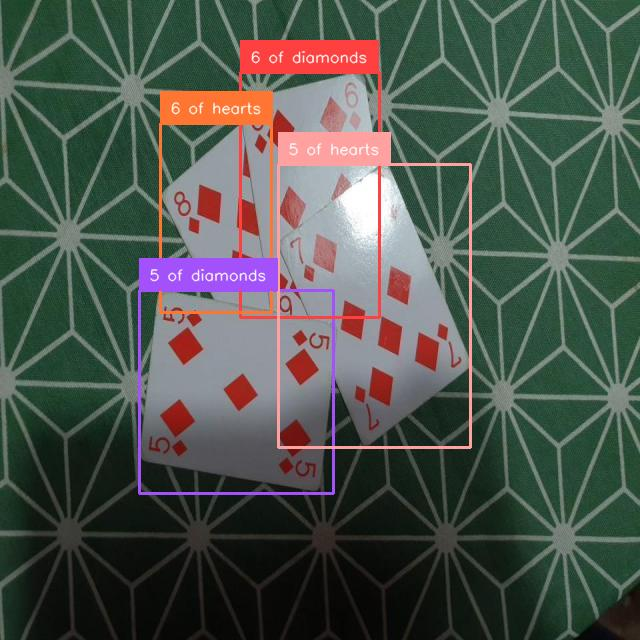

Training Epoch 4/5: 100%|██████████| 136/136 [03:39<00:00,  1.61s/it]


Average Training Loss: 2.4684637153849884


Validation Epoch 4/5: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Average Validation Loss: 1.9002136439085007



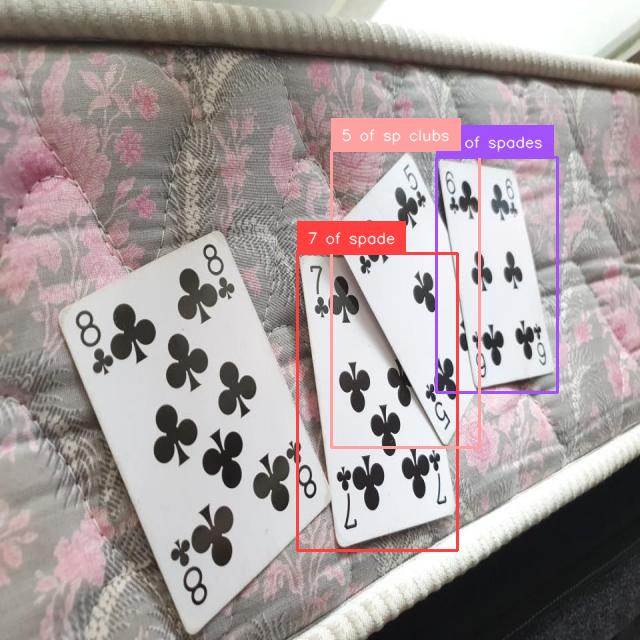
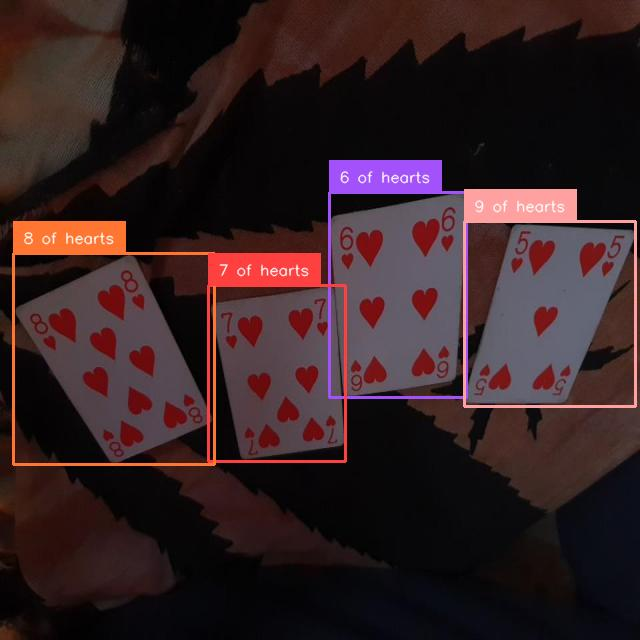
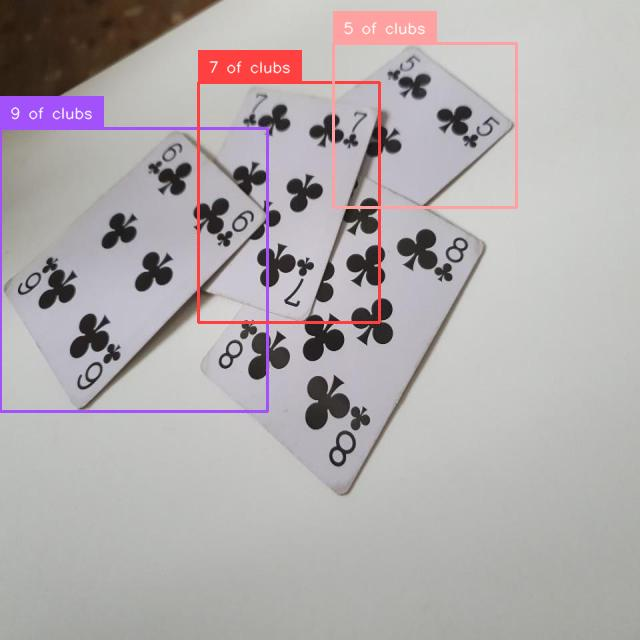
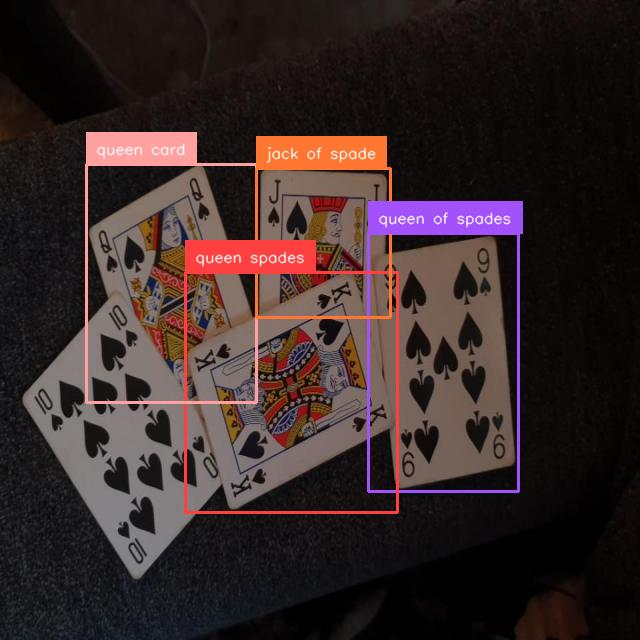
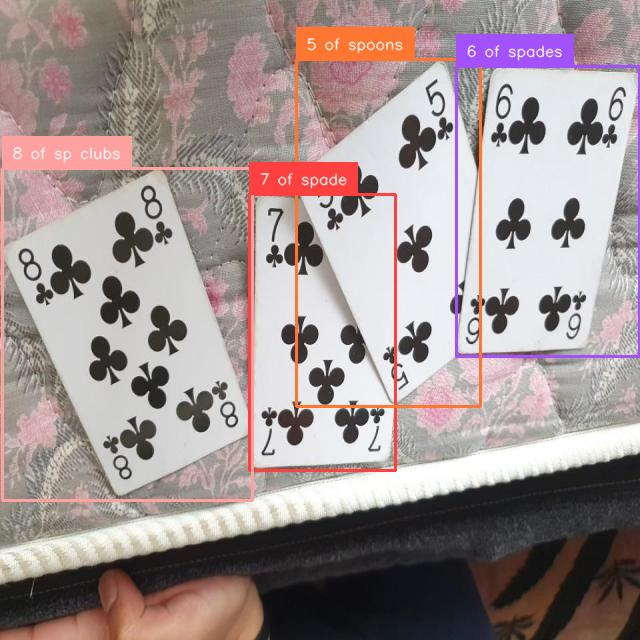
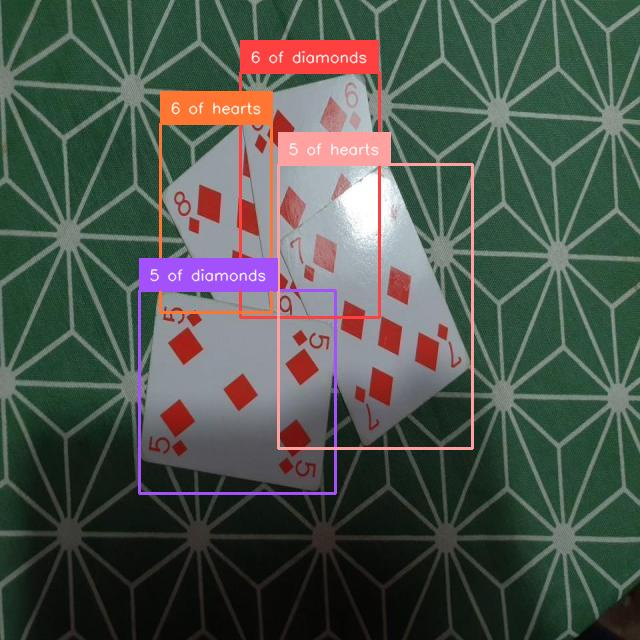

Training Epoch 5/5: 100%|██████████| 136/136 [03:39<00:00,  1.62s/it]


Average Training Loss: 2.2064856106744095


Validation Epoch 5/5: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Average Validation Loss: 1.830809697508812



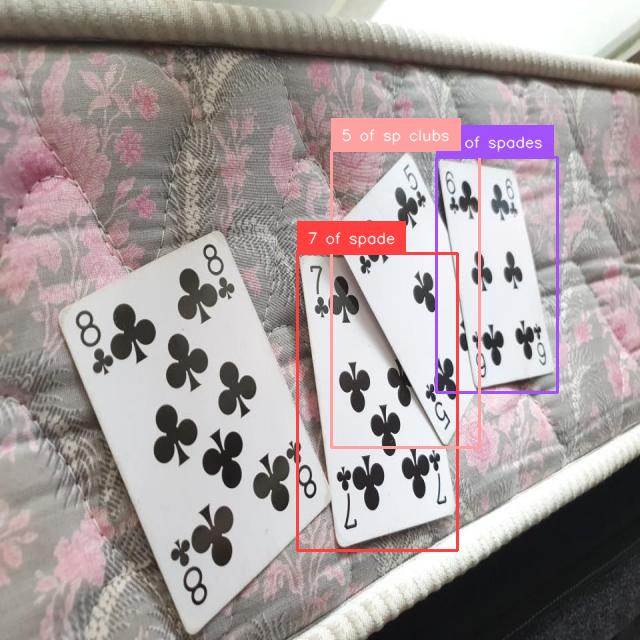
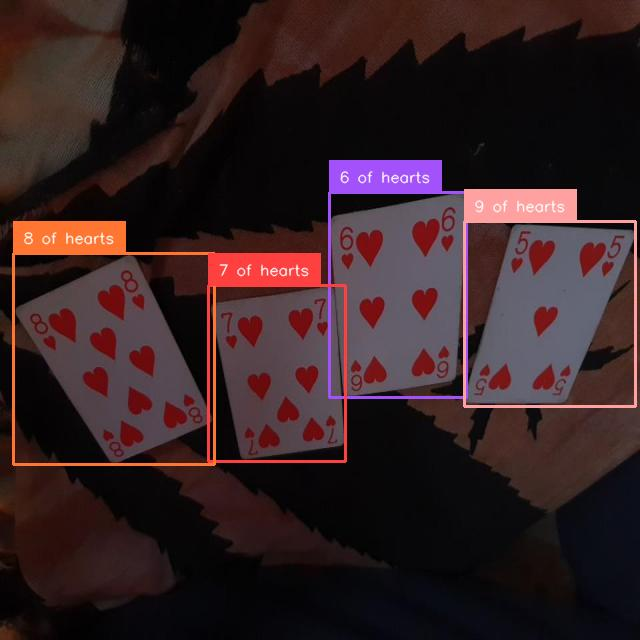
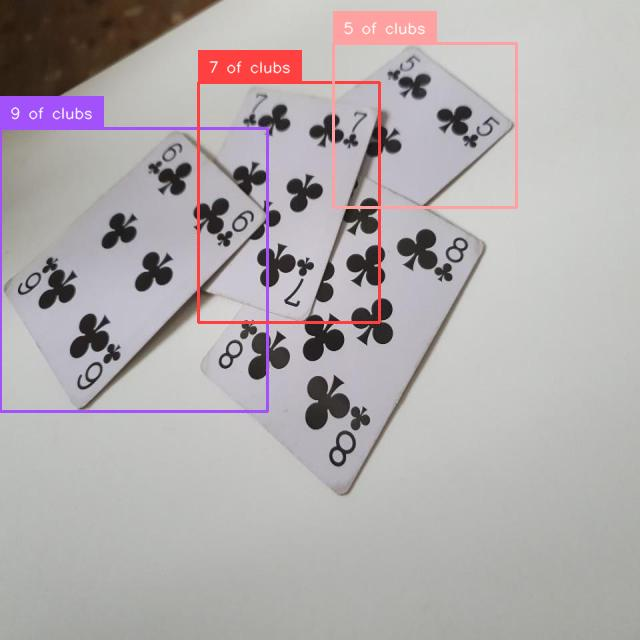
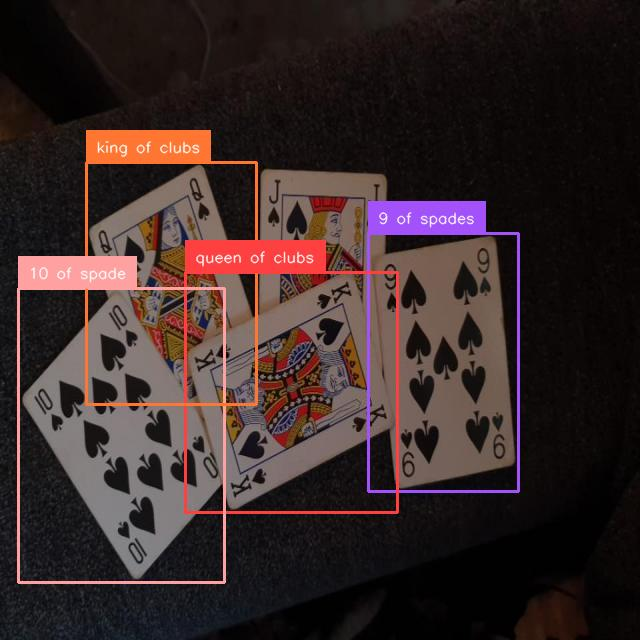
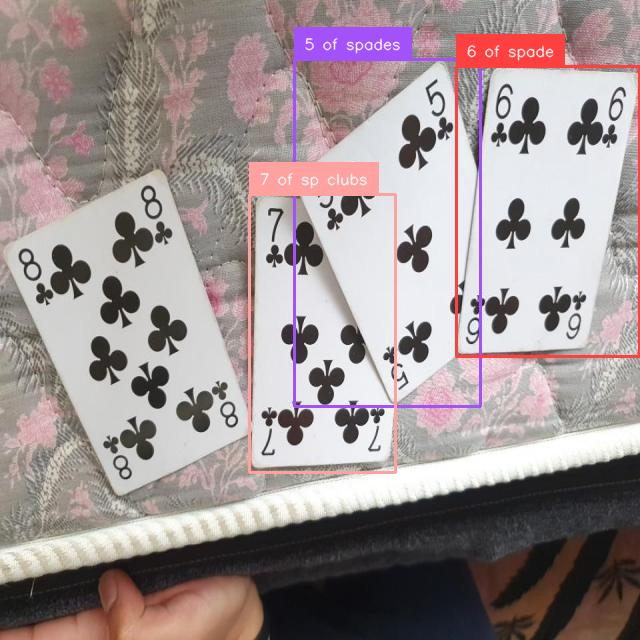
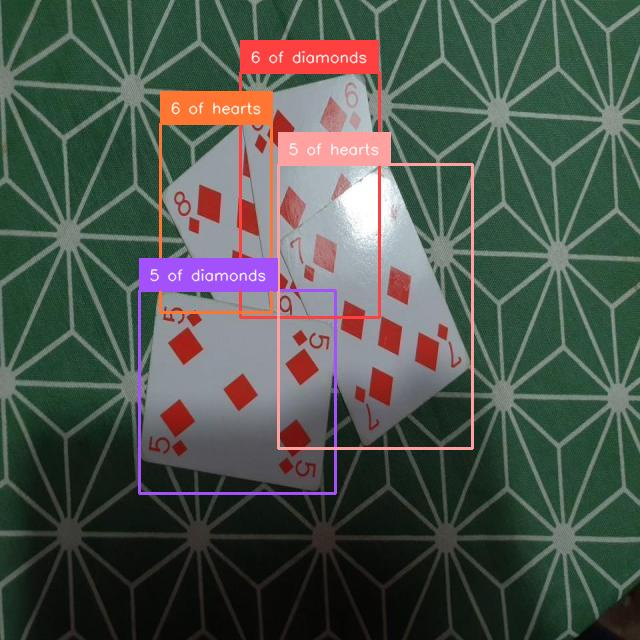

In [32]:
%%time

train_model(train_loader, val_loader, peft_model, processor, epochs=5, lr=5e-6)

## Fine-tuned model evaluation



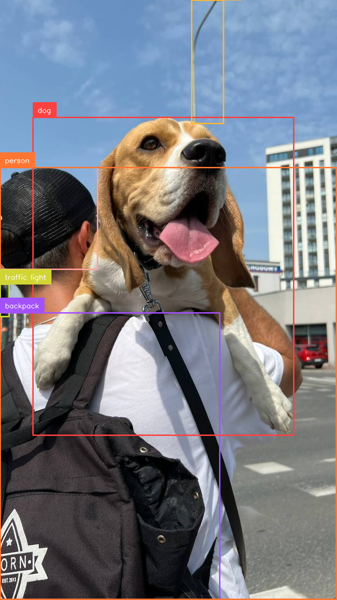

In [34]:
# @title Check if the model can still detect objects outside of the custom dataset

from PIL import Image

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<OD>"
text = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = peft_model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

**NOTE:** It seems that the model can still detect classes that don't belong to our custom dataset.

In [46]:
# @title Collect predictions
targets = []
predictions = []

for image_path, image, target in ds_valid:

    prefix = TASK
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    inputs = processor(text=prefix, images=image_pil, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    answer = processor.post_process_generation(generated_text, task=TASK, image_size=image_pil.size)

    prediction = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, answer, resolution_wh=image_pil.size)

    # clean up predictions - remove invalid class names, fill in the confidence field
    prediction = prediction[np.isin(prediction['class_name'], ds_valid.classes)]
    prediction.class_id = np.array([ds_valid.classes.index(class_name) for class_name in prediction['class_name']])
    prediction.confidence = np.ones(len(prediction))

    targets.append(target)
    predictions.append(prediction)

In [47]:
# @title Calculate mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.36
map50: 0.39
map75: 0.39


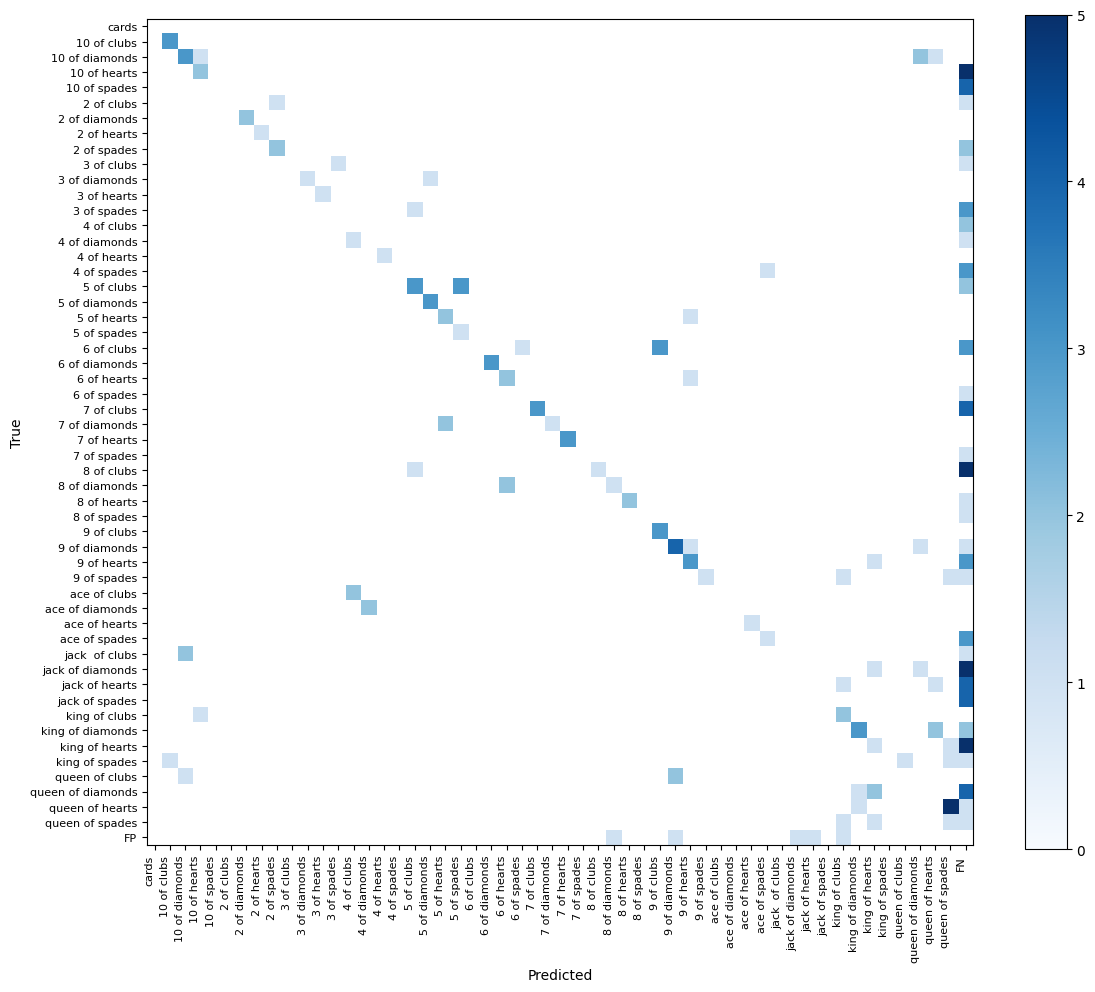

In [49]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds_valid.classes
)

_ = confusion_matrix.plot()

In [50]:
peft_model.save_pretrained("/content/florence2-lora")
processor.save_pretrained("/content/florence2-lora/")
!ls -la /content/florence2-lora/

total 11432
drwxr-xr-x 2 root root    4096 Jun 25 13:02 .
drwxr-xr-x 1 root root    4096 Jun 25 13:02 ..
-rw-r--r-- 1 root root     746 Jun 25 13:02 adapter_config.json
-rw-r--r-- 1 root root 7747264 Jun 25 13:02 adapter_model.safetensors
-rw-r--r-- 1 root root   22410 Jun 25 13:02 added_tokens.json
-rw-r--r-- 1 root root  456318 Jun 25 13:02 merges.txt
-rw-r--r-- 1 root root     947 Jun 25 13:02 preprocessor_config.json
-rw-r--r-- 1 root root    5102 Jun 25 13:02 README.md
-rw-r--r-- 1 root root  146627 Jun 25 13:02 special_tokens_map.json
-rw-r--r-- 1 root root  197658 Jun 25 13:02 tokenizer_config.json
-rw-r--r-- 1 root root 2297961 Jun 25 13:02 tokenizer.json
-rw-r--r-- 1 root root  798293 Jun 25 13:02 vocab.json


# Congratulations

⭐️ If you enjoyed this notebook, [**star the Roboflow Notebooks repo**](https://https://github.com/roboflow/notebooks) (and [**supervision**](https://github.com/roboflow/supervision) while you're at it) and let us know what tutorials you'd like to see us do next. ⭐️